# Towards interactive and reproducible QSAR models


A simple workflow for QSAR modeling.

## Data set pre-processing

### Import data from file

In [26]:
import pandas as pd

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import numpy as np

file = pd.read_csv('hdac1.csv') # Reads data from CSV file
IC50 = file['STANDARD_VALUE']
SMILES = file['CANONICAL_SMILES']

### Convert IC$_{50}$ to pIC$_{50}$

In [27]:
from math import log10

np_ic50 = np.array(IC50)

pIC50 = []
for i in np_ic50:
    molar = i*(10**-9) # Converts nM to M
    pIC50.append(-log10(molar))
Y = pIC50

with open('IC50.txt', 'wb') as f:
    f.write(b'STANDARD_VALUE\n')
    np.savetxt(f, Y, fmt="%s")

### Remove salts and counterions

In [28]:
import rdkit
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem import MolFromSmiles,MolToSmiles

remover = SaltRemover()
len(remover.salts)

SMILES_desalt = []

for i in SMILES:
    mol = MolFromSmiles(i) 
    mol_desalt = remover.StripMol(mol)
    mol_SMILES = MolToSmiles(mol_desalt)
    SMILES_desalt.append(mol_SMILES)

np_smiles = np.array(SMILES_desalt)

with open('SMILES.txt', 'wb') as f:
    f.write(b'CANONICAL_SMILES\n')
    np.savetxt(f, np_smiles, fmt="%s")

## Descriptor calculation

Each molecule are encoded by a set of **Morgan fingerprint** descriptors.

In [66]:
mols = Chem.SmilesMolSupplier("SMILES.txt")
#mols = Chem.SDMolSupplier("molecule.sdf")
fps = [AllChem.GetMorganFingerprintAsBitVect(m, 1) for m in mols]
np_fps = []
for fp in fps:
  arr = np.zeros((1,))
  DataStructs.ConvertToNumpyArray(fp, arr)
  np_fps.append(arr)
np.savetxt("hdac1-morgan-descriptors.csv", np_fps, delimiter=",")

## Remove useless features

In [67]:
from sklearn.feature_selection import VarianceThreshold

X0 = np.array(np_fps)
sel = VarianceThreshold(threshold=(0.95 * (1 - 0.95)))
X = sel.fit_transform(X0)
print "The initial set of " + str(len(np_fps[0])) + " descriptors has been reduced to " + str(len(X[0])) + " descriptors."

The initial set of 2048 descriptors has been reduced to 159 descriptors.


## Data split using 70/30 ratio

In [68]:
from sklearn.cross_validation import train_test_split

X_internal, X_external, Y_internal, Y_external = train_test_split(X, Y, test_size=0.3, random_state=0)

## Build a Random Forest model

In [69]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import cross_validation

# Training set
rf = RandomForestRegressor(n_estimators=500, max_features='sqrt', n_jobs=-1)
rf.fit(X_internal,Y_internal)
prediction = rf.predict(X_internal)

# Cross-validation
cv = cross_validation.cross_val_predict(rf, X_internal, Y_internal, cv=10, n_jobs=-1)

# External set
rf_external = RandomForestRegressor(n_estimators=500, max_features='sqrt', n_jobs=-1)
rf_external.fit(X_internal,Y_internal)
prediction_external = rf.predict(X_external)


## Plot Results


Training set
------------
N: 1876
R2: 0.9097
RMSE: 0.3275

Cross-validation set
------------
N: 1876
R2: 0.6273
RMSE: 0.6655

External set
------------
N: 804
R2: 0.6177
RMSE: 0.6948


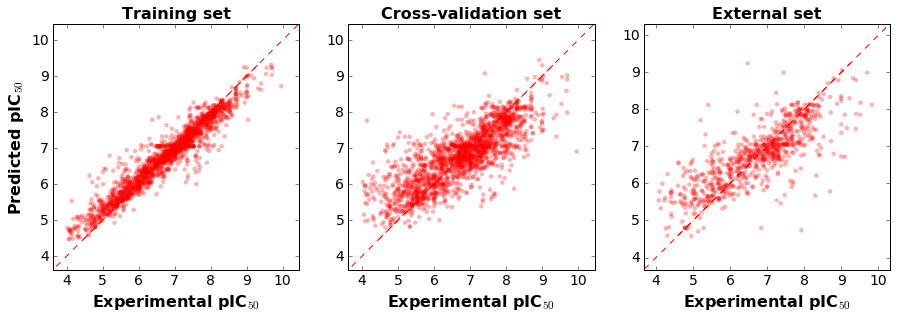

In [70]:
%matplotlib inline
from matplotlib import pyplot
figure,(plt1,plt2,plt3) = pyplot.subplots(1,3)
figure.set_size_inches(15,5)

# Code for extending the trend line
def extended(ax, x, y, **args):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_ext = np.linspace(xlim[0], xlim[1], 100)
    p = np.polyfit(x, y , deg=1)
    y_ext = np.poly1d(p)(x_ext)
    ax.plot(x_ext, y_ext, **args)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    return ax

# Training set
plt1.scatter(Y_internal, prediction, c='red', alpha=0.3, edgecolors='none')
plt1 = extended(plt1, [prediction.min(), prediction.max()], [prediction.min(), prediction.max()], color="r", lw=1, ls='--')
plt1.plot([prediction.min(), prediction.max()], [prediction.min(), prediction.max()], color="r", lw=1, ls='--')
plt1.set_aspect('equal')
plt1.set_title('Training set', fontsize=16, fontweight='bold')
min_axis = np.min(np.concatenate([Y_internal, prediction], axis=0))
max_axis = np.max(np.concatenate([Y_internal, prediction], axis=0))
plt1.set_xlabel(r'Experimental pIC$_{50}$', fontsize=16, fontweight='bold')
plt1.set_ylabel(r'Predicted pIC$_{50}$', fontsize=16, fontweight='bold')
plt1.set_xlim([(min_axis*0.9),(max_axis*1.05)])
plt1.set_ylim([(min_axis*0.9),(max_axis*1.05)])
plt1.tick_params(axis='both', which='major', labelsize=14)

# Cross-validation set
plt2.scatter(Y_internal, cv, c='red', alpha=0.3, edgecolors='none')
plt2 = extended(plt2, [prediction.min(), prediction.max()], [prediction.min(), prediction.max()], color="r", lw=1, ls='--')
plt2.plot([prediction.min(), prediction.max()], [prediction.min(), prediction.max()], color="r", lw=1, ls='--')
plt2.set_aspect('equal')
plt2.set_title('Cross-validation set', fontsize=16, fontweight='bold')
min_axis = np.min(np.concatenate([Y_internal, cv], axis=0))
max_axis = np.max(np.concatenate([Y_internal, cv], axis=0))
plt2.set_xlabel(r'Experimental pIC$_{50}$', fontsize=16, fontweight='bold')
#plt2.set_ylabel(r'Predicted pIC$_{50}$', fontsize=16, fontweight='bold')
plt2.set_xlim([(min_axis*0.9),(max_axis*1.05)])
plt2.set_ylim([(min_axis*0.9),(max_axis*1.05)])
plt2.tick_params(axis='both', which='major', labelsize=14)

# External set
plt3.scatter(Y_external, prediction_external, c='red', alpha=0.3, edgecolors='none')
plt3 = extended(plt3, [prediction_external.min(), prediction_external.max()], [prediction_external.min(), prediction_external.max()], color="r", lw=1, ls='--')
plt3.plot([prediction_external.min(), prediction_external.max()], [prediction_external.min(), prediction_external.max()], color="r", lw=1, ls='--')
plt3.set_aspect('equal')
plt3.set_title('External set', fontsize=16, fontweight='bold')
min_axis = np.min(np.concatenate([Y_external, prediction_external], axis=0))
max_axis = np.max(np.concatenate([Y_external, prediction_external], axis=0))
plt3.set_xlabel(r'Experimental pIC$_{50}$', fontsize=16, fontweight='bold')
#plt3.set_ylabel(r'Predicted pIC$_{50}$', fontsize=16, fontweight='bold')
plt3.set_xlim([(min_axis*0.9),(max_axis*1.05)])
plt3.set_ylim([(min_axis*0.9),(max_axis*1.05)])
plt3.tick_params(axis='both', which='major', labelsize=14)

# Print results
print '\nTraining set\n------------'
print 'N: ' + (str(len(X_internal)))
print 'R2: %0.4f'%(r2_score(Y_internal, prediction))
print 'RMSE: %0.4f'%(np.sqrt(mean_squared_error(Y_internal, prediction)))

print '\nCross-validation set\n------------'
print 'N: ' + (str(len(X_internal)))
print 'R2: %0.4f'%(r2_score(Y_internal, cv))
print 'RMSE: %0.4f'%(np.sqrt(mean_squared_error(Y_internal, cv)))

print '\nExternal set\n------------'
print 'N: ' + (str(len(X_external)))
print 'R2: %0.4f'%(r2_score(Y_external, prediction_external))
print 'RMSE: %0.4f'%(np.sqrt(mean_squared_error(Y_external, prediction_external)))

# <center>.....</center>